In [1]:
import sys
import os
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import hopsworks
import pandas as pd
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error
import joblib
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import src.config as config
from src.data_utils import transform_ts_data_info_features_and_target
from src.data_utils import split_time_series_data
from src.pipeline_utils import get_pipeline
from src.inference import load_model_from_registry
from src.inference import get_model_predictions

c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME, api_key_value=config.HOPSWORKS_API_KEY
)

feature_store = project.get_feature_store()
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

2025-03-05 05:40:05,772 INFO: Initializing external client
2025-03-05 05:40:05,779 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-05 05:40:06,916 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1214689


In [3]:
# Create a feature view if it doesn't already exist
try:
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all(),
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) created successfully.")
except Exception as e:
    print(f"Error creating feature view: {e}")

# Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Error creating feature view: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/1214689/featurestores/1202324/featureview). Server response: 
HTTP code: 400, HTTP reason: Bad Request, body: b'{"errorCode":270179,"usrMsg":"Feature view: time_series_hourly_feature_view, version: 1","errorMsg":"The provided feature view name and version already exists"}', error code: 270179, error msg: The provided feature view name and version already exists, user msg: Feature view: time_series_hourly_feature_view, version: 1
Feature view 'time_series_hourly_feature_view' (version 1) retrieved successfully.


In [4]:
ts_data, _ = feature_view.training_data(
    description="Time-series hourly taxi rides"
)
ts_data = ts_data.sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)
ts_data.head()
ts_data["pickup_hour"].min()
ts_data["pickup_hour"].max()
ts_data_copy = ts_data.copy()
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")
ts_data.info()
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None)
ts_data.info()
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")  # Year-Month format
ts_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (25.24s) 


,pickup_hour,pickup_location_id,rides
0,2023-01-01 00:00:00+00:00,2,0
1,2023-01-01 01:00:00+00:00,2,0
2,2023-01-01 02:00:00+00:00,2,0
3,2023-01-01 03:00:00+00:00,2,0
4,2023-01-01 04:00:00+00:00,2,0


'2023-01-01 00:00:00+00:00'

'2025-03-05 10:00:00+00:00'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456235 entries, 0 to 2456234
Data columns (total 3 columns):
 #   Column              Dtype              
---  ------              -----              
 0   pickup_hour         datetime64[ns, UTC]
 1   pickup_location_id  int32              
 2   rides               int32              
dtypes: datetime64[ns, UTC](1), int32(2)
memory usage: 37.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456235 entries, 0 to 2456234
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  int32         
 2   rides               int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 37.5 MB


,pickup_hour,pickup_location_id,rides,year_month
0,2023-01-01 00:00:00,2,0,2023-01
1,2023-01-01 01:00:00,2,0,2023-01
2,2023-01-01 02:00:00,2,0,2023-01
3,2023-01-01 03:00:00,2,0,2023-01
4,2023-01-01 04:00:00,2,0,2023-01
...,...,...,...,...
2456230,2025-03-05 06:00:00,263,70,2025-03
2456231,2025-03-05 07:00:00,263,128,2025-03
2456232,2025-03-05 08:00:00,263,147,2025-03
2456233,2025-03-05 09:00:00,263,167,2025-03


Text(0.5, 1.0, 'Number of Hours by Year/Month')

Text(0.5, 0, 'Year-Month')

Text(0, 0.5, 'Count of Hours')

[Text(0, 0, '2023-01'),
 Text(1, 0, '2023-02'),
 Text(2, 0, '2023-03'),
 Text(3, 0, '2023-04'),
 Text(4, 0, '2023-05'),
 Text(5, 0, '2023-06'),
 Text(6, 0, '2023-07'),
 Text(7, 0, '2023-08'),
 Text(8, 0, '2023-09'),
 Text(9, 0, '2023-10'),
 Text(10, 0, '2023-11'),
 Text(11, 0, '2023-12'),
 Text(12, 0, '2025-02'),
 Text(13, 0, '2025-03')]

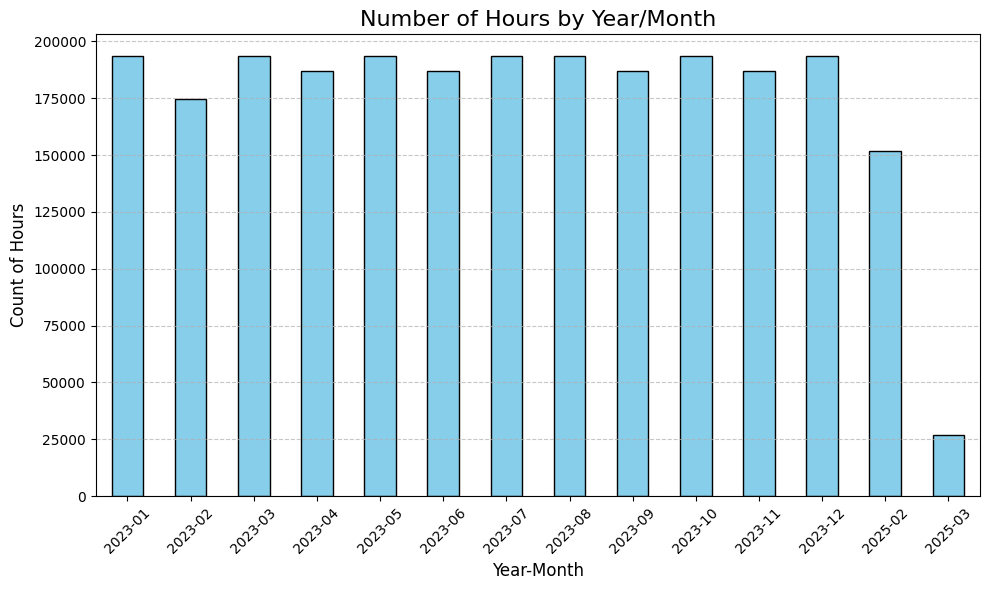

In [5]:
# Group by year_month and count
hour_counts = ts_data.groupby("year_month").size()

# Plot the data
ax = hour_counts.plot(kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black")  # Use 'ax' to store the plot object
ax.set_title("Number of Hours by Year/Month", fontsize=16)
ax.set_xlabel("Year-Month", fontsize=12)
ax.set_ylabel("Count of Hours", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [6]:
ts_data.head()
gte = ts_data["year_month"] >= pd.Period("2023-01", freq="M")
lte = ts_data["year_month"] <= pd.Period("2023-12", freq="M")
cond = gte & lte
filtered_data = ts_data[cond].reset_index(drop=True)
filtered_data.drop(columns=["year_month"], inplace=True) 
filtered_data.shape
ts_data = filtered_data
ts_data.info()
ts_data.head()["pickup_hour"].values

,pickup_hour,pickup_location_id,rides,year_month
0,2023-01-01 00:00:00,2,0,2023-01
1,2023-01-01 01:00:00,2,0,2023-01
2,2023-01-01 02:00:00,2,0,2023-01
3,2023-01-01 03:00:00,2,0,2023-01
4,2023-01-01 04:00:00,2,0,2023-01


(2277600, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277600 entries, 0 to 2277599
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  int32         
 2   rides               int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 34.8 MB


array(['2023-01-01T00:00:00.000000000', '2023-01-01T01:00:00.000000000',
       '2023-01-01T02:00:00.000000000', '2023-01-01T03:00:00.000000000',
       '2023-01-01T04:00:00.000000000'], dtype='datetime64[ns]')

In [7]:
features, targets = transform_ts_data_info_features_and_target(ts_data, window_size=24*28, step_size=23)
features.sort_values(["pickup_location_id", "pickup_hour"]).head(5)
features[features["pickup_location_id"] == 2].head(5)
features_copy = features.copy()
features_targets = features.copy()
features_targets["target"] = targets
features_targets.shape

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2023-01-29 00:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-29 23:00:00,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-30 22:00:00,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-31 21:00:00,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-02-01 20:00:00,2


,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2023-01-29 00:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-29 23:00:00,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-30 22:00:00,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-31 21:00:00,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-02-01 20:00:00,2


(91520, 675)

In [8]:
# Define the cutoff date as 28 days before today  
cutoff_date = pd.Timestamp(datetime.now() - timedelta(days=28))  
cutoff_date

Timestamp('2025-02-05 05:42:03.501223')

In [9]:
X_train, y_train, X_test, y_test = split_time_series_data(
    features_targets,
    cutoff_date=cutoff_date,
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(91520, 674)
(91520,)
(0, 674)
(0,)


In [10]:
X_train.info()
pipeline = get_pipeline()
pipeline.fit(features, targets)
predictions = pipeline.predict(features)
predictions
test_mae = mean_absolute_error(targets, predictions)
print(f"{test_mae:.4f}")

joblib.dump(pipeline, config.MODELS_DIR / "lgb_model.pkl")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91520 entries, 0 to 91519
Columns: 674 entries, rides_t-672 to pickup_location_id
dtypes: datetime64[ns](1), int32(1), int64(672)
memory usage: 470.3 MB
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.214808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171646
[LightGBM] [Info] Number of data points in the train set: 91520, number of used features: 675
[LightGBM] [Info] Start training from score 16.630299


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function average_rides_last_4_weeks at 0x00000246220645E0>)),
                ('temporalfeatureengineer', TemporalFeatureEngineer()),
                ('lgbmregressor', LGBMRegressor())])

array([ 0.16632143,  0.16632143,  0.16632143, ..., 83.42269769,
       75.76323756, 60.66289631])

1.9355


['C:\\Users\\singh\\Downloads\\CDS500_Applied_ML_DS\\Projects\\CDA500P1\\models\\lgb_model.pkl']

In [11]:
input_schema = Schema(features)
output_schema = Schema(targets)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [12]:
model_registry = project.get_model_registry()

model = model_registry.sklearn.create_model(
    name="taxi_demand_predictor_next_hour",
    metrics={"test_mae": test_mae},
    description="LightGBM regressor",
    input_example=features.sample(),
    model_schema=model_schema,
    #include_files=["src/", "requirements.txt"]  # Include directories and files
)
# https://community.hopsworks.ai/t/attributeerror-windowspath-object-has-no-attribute-startswith/1003
# model.save(config.MODELS_DIR / 'lgb_model.pkl')
model.save(r'C:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\models\lgb_model.pkl')

Uploading: 100.000%|██████████| 317921/317921 elapsed<00:01 remaining<00:00  1.01s/it]
Uploading: 100.000%|██████████| 2048/2048 elapsed<00:02 remaining<00:000:06,  1.70s/it]
Uploading: 100.000%|██████████| 51418/51418 elapsed<00:01 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:13<00:00,  2.25s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/1214689/models/taxi_demand_predictor_next_hour/6


Model(name: 'taxi_demand_predictor_next_hour', version: 6)

In [13]:
model = load_model_from_registry()
preds = get_model_predictions(model, features_copy)
preds.head(5)
test_mae = mean_absolute_error(targets, preds["predicted_demand"])
print(f"{test_mae:.4f}")

2025-03-05 05:42:28,681 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-03-05 05:42:28,698 INFO: Initializing external client
2025-03-05 05:42:28,699 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-05 05:42:29,370 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1214689


,pickup_location_id,predicted_demand
0,2,0.0
1,2,0.0
2,2,0.0
3,2,0.0
4,2,0.0


1.8374
